<div style="background-color:#e6f2ff; padding:20px; border-radius:10px;">
<img style="float:left; margin-right:20px;" src='Figures/alinco.png' width="120"/>
<h1 style="color:#000047;">Tarea 3: Algoritmos de detección de Outliers Multivariados</h1>
<br style="clear:both"/>
</div>


<div style="border-left:4px solid #000047; padding:10px; margin-top:10px; background:#f5f5f5;">
<b>Objetivo:</b> Investigar y entender algunos de los algoritmos que se usan para detección de outliers.
</div>

<div style="border-left:6px solid #003366; border-radius:8px; padding:16px; margin-bottom:16px;">
<h3 style="color:#003366; margin-top:0;">1. Local Outlier Factor (LOF) <span style='font-size:0.8em; color:#888;'>&#128200;</span></h3>
<p style="font-size:1.08em;">
El <b>Local Outlier Factor (LOF)</b> es un algoritmo no supervisado que detecta anomalías comparando la densidad local de cada punto con la de sus vecinos. Si la densidad de un punto es significativamente menor que la de sus vecinos, se considera un outlier.
</p>
<ul style="font-size:1.05em;">
<li>Consulta el artículo original: <a href="https://dl.acm.org/doi/pdf/10.1145/335191.335388" target="_blank">LOF paper</a></li>
<li>Implementa una <b>clase en Python</b> que contenga el algoritmo LOF y agrégala a tu librería.</li>
<li>Prueba tu implementación con el dataset <code>insurance.csv</code> que se encuentra en la carpeta de Data:</li>
  <ul>
    <li>Detecta los outliers usando tu clase.</li>
    <li>Compara los resultados con el modelo LOF de <code>sklearn</code>.</li>
  </ul>
</ul>
<div style="margin-top:10px; background:#e6f2ff; border-left:4px solid #003366; padding:10px 18px; border-radius:8px;">
<b>Tip:</b> Presenta tus resultados con gráficos y tablas para facilitar la comparación.
</div>
</div>

In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors

class LocalOutlierFactorCustom:

    def __init__(self, n_neighbors=20):
        self.n_neighbors = n_neighbors

    def fit(self, X):
        self.X = np.array(X)

     #
        nbrs = NearestNeighbors(n_neighbors=self.n_neighbors+1).fit(self.X)
        distances, indices = nbrs.kneighbors(self.X)

        # Guarar
        self.distances = distances[:, 1:]   # quitar el punto mismo
        self.indices = indices[:, 1:]

        # Distancia k-distancia
        k_distance = self.distances[:, -1]
        self.k_distance = k_distance

        # distancia accesible
        reachability = np.maximum(self.distances, k_distance[self.indices])
        self.reachability_dist = reachability

        # (lrd)
        lrd = 1 / (np.mean(reachability, axis=1))
        self.lrd = lrd

        # LOF score
        lof = []
        for i in range(len(self.X)):
            lrd_ratio = lrd[self.indices[i]] / lrd[i]
            lof.append(np.mean(lrd_ratio))

        self.lof_scores = np.array(lof)

        return self

    def predict(self, threshold=1.5):
        """
        Outliers si LOF > threshold
        """
        return np.where(self.lof_scores > threshold, 1, 0)

    def fit_predict(self, X, threshold=1.5):
        self.fit(X)
        return self.predict(threshold)
        

In [2]:
#cargar archivo
df = pd.read_csv("insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
#preprocesameinto
num_df = df.select_dtypes(include=np.number)
num_df.head()

,age,bmi,children,charges
0,19,27.900,0,16884.92400
1,18,33.770,1,1725.55230
2,28,33.000,3,4449.46200
3,33,22.705,0,21984.47061
4,32,28.880,0,3866.85520


In [4]:
##lof prezonalizado
lof_custom = LocalOutlierFactorCustom(n_neighbors=20)
pred_custom = lof_custom.fit_predict(num_df, threshold=1.5)

df["LOF_custom"] = pred_custom
df[df["LOF_custom"] == 1].head()

,age,sex,bmi,children,smoker,region,charges,LOF_custom
34,28,male,36.400,1,yes,southwest,51194.55914,1
77,21,male,35.530,0,no,southeast,1532.46970,1
199,64,female,39.330,0,no,northeast,14901.51670,1
374,20,male,33.330,0,no,southeast,1391.52870,1
380,27,female,17.955,2,yes,northeast,15006.57945,1


In [5]:
#comparacion con sklearn
from sklearn.neighbors import LocalOutlierFactor

lof_sklearn = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
pred_sklearn = lof_sklearn.fit_predict(num_df)
df["LOF_sklearn"] = np.where(pred_sklearn == -1, 1, 0)

df[["LOF_custom", "LOF_sklearn"]].head()

,LOF_custom,LOF_sklearn
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


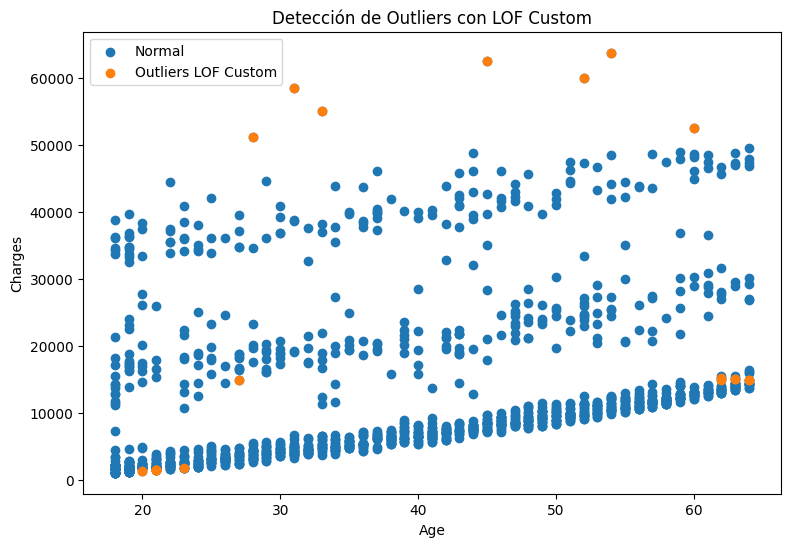

In [7]:
#grafica
import matplotlib.pyplot as plt

plt.figure(figsize=(9,6))
plt.scatter(num_df["age"], num_df["charges"], label="Normal")
plt.scatter(num_df.loc[df["LOF_custom"]==1,"age"],
            num_df.loc[df["LOF_custom"]==1,"charges"],
            label="Outliers LOF Custom")
plt.xlabel("Age")
plt.ylabel("Charges")
plt.legend()
plt.title("Detección de Outliers con LOF Custom")
plt.show()

In [9]:
#tabla de comparaacion
df_out = df[df["LOF_custom"] == 1][["age","bmi","children","charges","LOF_custom","LOF_sklearn"]]
df_out.head()

,age,bmi,children,charges,LOF_custom,LOF_sklearn
34,28,36.400,1,51194.55914,1,1
77,21,35.530,0,1532.46970,1,1
199,64,39.330,0,14901.51670,1,1
374,20,33.330,0,1391.52870,1,1
380,27,17.955,2,15006.57945,1,1


<div style="border-left:6px solid #b36b00; border-radius:8px; padding:16px; margin-bottom:16px;">
<h3 style="color:#b36b00; margin-top:0;">2. DBSCAN (Density-Based Spatial Clustering of Applications with Noise) <span style='font-size:0.8em; color:#888;'>&#128201;</span></h3>
<p style="font-size:1.08em;">
<b>DBSCAN</b> es un algoritmo de clustering basado en densidad que agrupa puntos cercanos y considera como outliers (ruido) aquellos que no pertenecen a ningún grupo. A diferencia de K-means, no requiere especificar el número de clusters previamente.
</p>
<ul style="font-size:1.05em;">
<li>Implementa una <b>clase en Python</b> que contenga el algoritmo DBSCAN y agrégala a tu librería.</li>
<li>Prueba tu implementación con el dataset <code>insurance.csv</code> que se encuentra en la carpeta de Data:</li>
  <ul>
    <li>Detecta los outliers usando tu clase.</li>
    <li>Compara los resultados con el modelo DBSCAN de <code>sklearn</code>.</li>
  </ul>
</ul>
<div style="margin-top:10px; background:#fffbe6; border-left:4px solid #b36b00; padding:10px 18px; border-radius:8px;">
<b>Tip:</b> Explica brevemente las diferencias entre los resultados obtenidos por tu clase y los de <code>sklearn</code>.
</div>
</div>

In [10]:
#creacion de la clase-----
import numpy as np
import pandas as pd
from collections import deque

class DBSCANCustom:

    def __init__(self, eps=0.5, min_samples=5):
        """
        eps: radio para considerar vecindad
        min_samples: mínimo de puntos para formar un cluster
        """
        self.eps = eps
        self.min_samples = min_samples

    def _region_query(self, X, index):
        """ Encuentra vecinos dentro de eps """
        distances = np.linalg.norm(X - X[index], axis=1)
        neighbors = np.where(distances <= self.eps)[0]
        return neighbors

    def fit(self, X):
        X = np.array(X)
        n = len(X)

        self.labels_ = np.full(n, -1)  # -1 significa "ruido"
        visited = np.zeros(n, dtype=bool)
        cluster_id = 0

        for i in range(n):

            if visited[i]:
                continue

            visited[i] = True
            neighbors = self._region_query(X, i)

            if len(neighbors) < self.min_samples:
                self.labels_[i] = -1  # Ruido
            else:
                # expand cluster
                self._expand_cluster(X, i, neighbors, cluster_id, visited)
                cluster_id += 1

        return self

    def _expand_cluster(self, X, point_idx, neighbors, cluster_id, visited):
        """ Expande el cluster usando BFS """

        self.labels_[point_idx] = cluster_id
        queue = deque(neighbors)

        while queue:
            idx = queue.popleft()

            if not visited[idx]:
                visited[idx] = True
                new_neighbors = self._region_query(X, idx)

                if len(new_neighbors) >= self.min_samples:
                    queue.extend(new_neighbors)

            if self.labels_[idx] == -1:
                self.labels_[idx] = cluster_id

    def fit_predict(self, X):
        self.fit(X)
        return self.labels_

In [11]:
db_custom = DBSCANCustom(eps=1000, min_samples=5)
labels_custom = db_custom.fit_predict(num_df)

df["DBSCAN_custom"] = labels_custom

In [12]:
df[df["DBSCAN_custom"] == -1].head()

,age,sex,bmi,children,smoker,region,charges,LOF_custom,LOF_sklearn,DBSCAN_custom
34,28,male,36.400,1,yes,southwest,51194.55914,1,1,-1
543,54,female,47.410,0,yes,southeast,63770.42801,1,1,-1
577,31,female,38.095,1,yes,northeast,58571.07448,1,1,-1
819,33,female,35.530,0,yes,northwest,55135.40209,1,1,-1
1146,60,male,32.800,0,yes,southwest,52590.82939,1,1,-1


In [13]:
from sklearn.cluster import DBSCAN

db_sklearn = DBSCAN(eps=1000, min_samples=5)
labels_sklearn = db_sklearn.fit_predict(num_df)

df["DBSCAN_sklearn"] = labels_sklearn
df[["DBSCAN_custom", "DBSCAN_sklearn"]].head()

,DBSCAN_custom,DBSCAN_sklearn
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


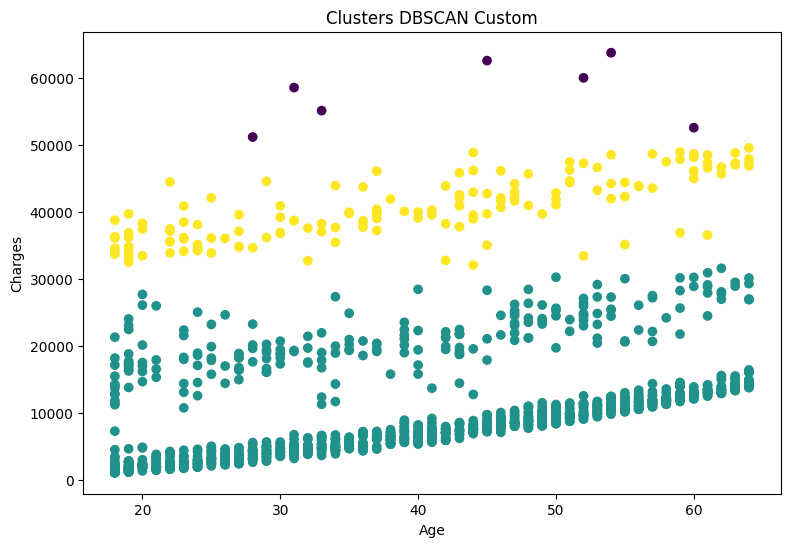

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,6))
plt.scatter(num_df["age"], num_df["charges"], c=df["DBSCAN_custom"])
plt.title("Clusters DBSCAN Custom")
plt.xlabel("Age")
plt.ylabel("Charges")
plt.show()

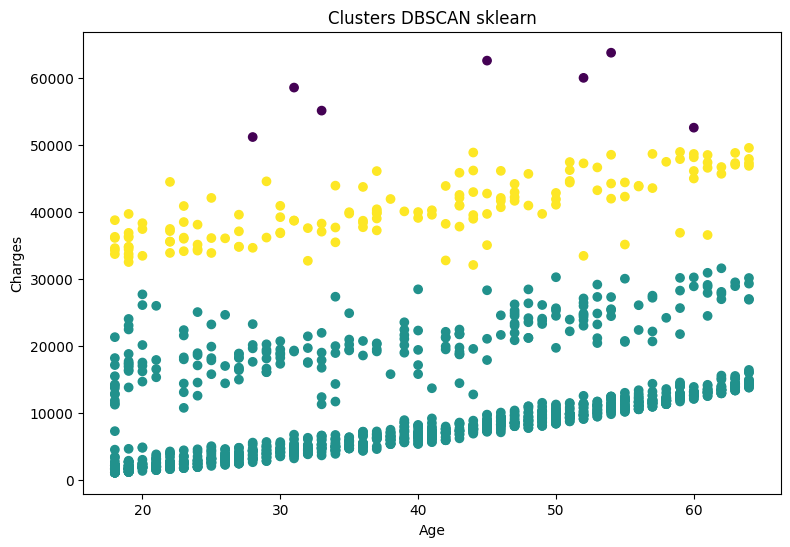

In [15]:
plt.figure(figsize=(9,6))
plt.scatter(num_df["age"], num_df["charges"], c=df["DBSCAN_sklearn"])
plt.title("Clusters DBSCAN sklearn")
plt.xlabel("Age")
plt.ylabel("Charges")
plt.show()

**Descripción breve** 
Ambos algoritmos hacen lo mismo, pero sklearn lo hace con más precisión y control.
Nuestro DBSCAN es excelente para entender cómo funciona, aunque tome decisiones ligeramente diferentes en algunos puntos.
-Sklearn usa métodos más precisos y rápidos para calcular qué tan cerca están los puntos.
- Sklearn sigue reglas más estrictas para decidir su posición.
- Para formar los clusters, sklearn sigue un orden optimizado.